In [1]:
import keras
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import ModelCheckpoint
import os
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import re
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.callbacks import ModelCheckpoint 
from keras import layers, regularizers

In [2]:
data = pd.read_csv("data_cleaned_shuffled.csv", sep=',')
data['text_cleaned_string'] = data['text_cleaned_string'].astype('str')
data.head()

,category,text_cleaned_string
0,negative,involuntarily bumped passenger cant guarantee ...
1,neutral,yeah suppose
2,negative,ick yo autocorrect ruse
3,positive,ill drinks anybody pull boy named sue johnnie ...
4,neutral,warned consuela gets quincenera emoji tasha be...


In [3]:
# clean the data
import re

def clean(text):
    text = re.sub("RT @[\w]*:", "", text)
    text = re.sub("@[\w]*", "", text)
    text = re.sub("https?://[A-Za-z0-9./]*", "", text)
    text = re.sub("\n", "", text)
    text = re.sub("[^a-zA-z\s]", "",text)
    return text.lower().split()

from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
def remove_stopwords(tokenized_sentence):
    return [token for token in tokenized_sentence if token not in set(stopwords.words("english"))]

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
data['text_cleaned_string'].values

array(['involuntarily bumped passenger cant guarantee another flight three days',
       'yeah suppose', 'ick yo autocorrect ruse', ...,
       'ok night sweet people i`ll look ya tomorrow',
       'get bumped pm birmingham delayed pilots scheduled dont enough hours together fail',
       'whats deal flight dca phl boarded time left gate mins late flight sat tarmac'],
      dtype=object)

In [4]:
max_fatures = 10000
tokenizer = Tokenizer(num_words=max_fatures, split=" ")
tokenizer.fit_on_texts(data['text_cleaned_string'].values)

In [ ]:
word_index = tokenizer.word_index
word_count = len(word_index)
print('total word count: ', word_count)

total word count:  42661


In [5]:
X = tokenizer.texts_to_sequences(data['text_cleaned_string'].values)
X = pad_sequences(X, maxlen = 32) 

Y = pd.get_dummies(data['category']).values
X_train_total, X_test, Y_train_total, Y_test = train_test_split(X, Y, test_size = 0.05, random_state = 42)

In [ ]:
# simple LSTM

embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(max_fatures, embed_dim,input_length = 32))
model.add(Dropout(0.5))
model.add(LSTM(lstm_out, dropout=0.5, recurrent_dropout=0.2))
model.add(Dense(3,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
save_best_model = ModelCheckpoint('best_model_total.h5', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
print(model.summary())

batch_size = 1024 
history = model.fit(X_train_total, 
            Y_train_total,
            epochs = 10, 
            batch_size=batch_size, 
            validation_data=(X_test, Y_test), 
            callbacks=[save_best_model]) 

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 32, 128)           1280000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 128)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 196)               254800    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 591       
Total params: 1,535,391
Trainable params: 1,535,391
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/10
56/56 [==============================] - 83s 1s/step - loss: 1.0522 - accuracy: 0.4318 - val_loss: 0.8151 - val_accuracy: 0.6437

Epoch 00001: val_accuracy improved from -inf to 0.64371, saving model to best_model_total.h5
Epo

In [ ]:
# Bi-LSTM
model2 = Sequential()
model2.add(layers.Embedding(max_fatures, embed_dim,input_length = 32))
model2.add(layers.Bidirectional(layers.LSTM(20,dropout=0.6,recurrent_dropout=0.2)))
model2.add(layers.Dense(3,activation='softmax'))
model2.compile(optimizer='rmsprop',loss='categorical_crossentropy', metrics=['accuracy'])
checkpoint2 = ModelCheckpoint("best_model_bilstm.h5", monitor='val_accuracy', verbose=1,save_best_only=True)
history2 = model2.fit(X_train_total, 
            Y_train_total, 
            epochs = 10, 
            batch_size=batch_size, 
            validation_data=(X_test, Y_test), 
            callbacks=[checkpoint2]) 

Epoch 1/10
56/56 [==============================] - 46s 744ms/step - loss: 1.0488 - accuracy: 0.4716 - val_loss: 0.8774 - val_accuracy: 0.6430

Epoch 00001: val_accuracy improved from -inf to 0.64305, saving model to best_model_bilstm.h5
Epoch 2/10
56/56 [==============================] - 41s 732ms/step - loss: 0.8294 - accuracy: 0.6535 - val_loss: 0.7486 - val_accuracy: 0.6956

Epoch 00002: val_accuracy improved from 0.64305 to 0.69561, saving model to best_model_bilstm.h5
Epoch 3/10
56/56 [==============================] - 41s 731ms/step - loss: 0.7121 - accuracy: 0.7096 - val_loss: 0.7131 - val_accuracy: 0.7039

Epoch 00003: val_accuracy improved from 0.69561 to 0.70393, saving model to best_model_bilstm.h5
Epoch 4/10
56/56 [==============================] - 41s 731ms/step - loss: 0.6612 - accuracy: 0.7276 - val_loss: 0.6987 - val_accuracy: 0.7112

Epoch 00004: val_accuracy improved from 0.70393 to 0.71124, saving model to best_model_bilstm.h5
Epoch 5/10
56/56 [=====================

In [ ]:
# CNN - better use GPU

from keras import layers, regularizers
from keras.layers import Dense, Input, Flatten
from keras.layers import Conv1D, MaxPooling1D, Embedding, Dropout
from keras.models import Model
embed_dim = 128
lstm_out = 196

# have to create a longer sequence for cnn training
X1000 = tokenizer.texts_to_sequences(data['text_cleaned_string'].values)
X1000 = pad_sequences(X1000, maxlen = 1000) 
Y = pd.get_dummies(data['category']).values
X_train_total1000, X_test1000, Y_train_total1000, Y_test1000 = train_test_split(X1000, Y, test_size = 0.05, random_state = 42)

embedding_layer = Embedding(word_count + 1, 256, input_length=1000) 
sequence_input = Input(shape=(1000,), dtype='int32')
embedded_sequences = embedding_layer(sequence_input)
l_cov1= Conv1D(128, 5, activation='relu')(embedded_sequences)
l_pool1 = MaxPooling1D(5)(l_cov1)
l_cov2 = Conv1D(128, 5, activation='relu')(l_pool1)
l_pool2 = MaxPooling1D(5)(l_cov2)
l_cov3 = Conv1D(128, 5, activation='relu')(l_pool2)
l_pool3 = MaxPooling1D(35)(l_cov3)  # global max pooling
l_flat = Flatten()(l_pool3)
l_dense = Dense(128, activation='relu')(l_flat)
preds = Dense(3, activation='softmax')(l_dense) 
 
model3 = Model(sequence_input, preds)
model3.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['acc'])

checkpoint3 = ModelCheckpoint("best_model_cnn.h5", monitor='val_acc', verbose=1,save_best_only=True)
history3 = model3.fit(X_train_total1000, 
            Y_train_total1000, 
            epochs = 10, 
            batch_size=1024, 
            validation_data=(X_test1000, Y_test1000), 
            callbacks=[checkpoint3]) 

Epoch 1/10
56/56 [==============================] - 841s 15s/step - loss: 1.0390 - acc: 0.4261 - val_loss: 0.8416 - val_acc: 0.6134

Epoch 00001: val_acc improved from -inf to 0.61344, saving model to best_model_cnn.h5
Epoch 2/10
56/56 [==============================] - 838s 15s/step - loss: 0.8006 - acc: 0.6382 - val_loss: 0.7987 - val_acc: 0.6457

Epoch 00002: val_acc improved from 0.61344 to 0.64571, saving model to best_model_cnn.h5
Epoch 3/10
56/56 [==============================] - 837s 15s/step - loss: 0.7235 - acc: 0.6900 - val_loss: 0.8161 - val_acc: 0.6351

Epoch 00003: val_acc did not improve from 0.64571
Epoch 4/10
56/56 [==============================] - 838s 15s/step - loss: 0.6599 - acc: 0.7248 - val_loss: 0.8215 - val_acc: 0.6494

Epoch 00004: val_acc improved from 0.64571 to 0.64937, saving model to best_model_cnn.h5
Epoch 5/10
56/56 [==============================] - 838s 15s/step - loss: 0.5782 - acc: 0.7653 - val_loss: 0.8893 - val_acc: 0.6347

Epoch 00005: val_acc 

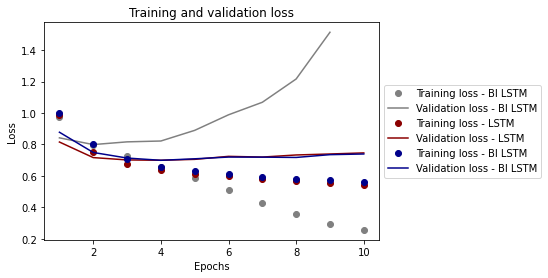

In [ ]:
import matplotlib.pyplot as plt 
loss2 = history2.history['loss']
val_loss2 = history2.history['val_loss']

loss = history.history['loss']
val_loss = history.history['val_loss']

loss3 = history3.history['loss']
val_loss3 = history3.history['val_loss']

epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss3, 'bo', label='Training loss - BI LSTM', color='grey')
plt.plot(epochs[:-1], val_loss3[:-1], 'b', label='Validation loss - BI LSTM', color='grey')
plt.plot(epochs, loss, 'bo', label='Training loss - LSTM', color='darkred')
plt.plot(epochs, val_loss, 'b', label='Validation loss - LSTM', color='darkred')
plt.plot(epochs, loss2, 'bo', label='Training loss - BI LSTM', color='darkblue')
plt.plot(epochs, val_loss2, 'b', label='Validation loss - BI LSTM', color='darkblue')
plt.title('Training and validation loss')
plt.xlabel('Epochs') 
plt.ylabel('Loss') 
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

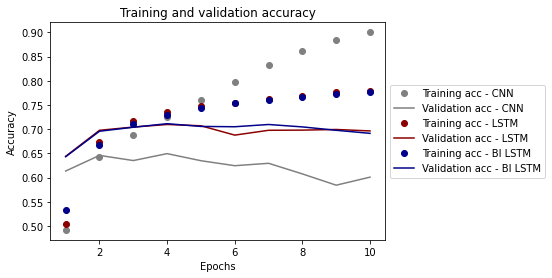

In [ ]:
plt.clf()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
acc2 = history2.history['accuracy']
val_acc2 = history2.history['val_accuracy']
acc3 = history3.history['acc']
val_acc3 = history3.history['val_acc']
plt.plot(epochs, acc3, 'bo', label='Training acc - CNN ', color = 'grey')
plt.plot(epochs, val_acc3, 'b', label='Validation acc - CNN', color = 'grey')
plt.plot(epochs, acc, 'bo', label='Training acc - LSTM ', color = 'darkred')
plt.plot(epochs, val_acc, 'b', label='Validation acc - LSTM', color = 'darkred')
plt.plot(epochs, acc2, 'bo', label='Training acc - BI LSTM', color = 'darkblue')
plt.plot(epochs, val_acc2, 'b', label='Validation acc - BI LSTM', color = 'darkblue')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show() 

In [30]:
import sklearn 
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

saved_model2 = load_model('best_model_bilstm.h5')
y_pred2 = saved_model2.predict(X_test) 
saved_model2.evaluate(X_test, Y_test, verbose=1)
y_pred_label2= np.argmax(y_pred2, axis = 1)

confusion_m2 = sklearn.metrics.confusion_matrix(np.argmax(Y_test, axis = 1), y_pred_label2, normalize ='true')

df_cm2 = pd.DataFrame(confusion_m2) 
df_cm2.columns = ["negative", "neutral", "positive"] 
df_cm2["ground_truth"] = ["negative", "neutral", "positive"]
df_cm2.set_index("ground_truth", inplace = True)
df_cm2.to_csv('confusion_matrix_ratio.csv')

94/94 [==============================] - 1s 10ms/step - loss: 0.6987 - accuracy: 0.7112


In [31]:
df_cm2

,negative,neutral,positive
ground_truth,,,
negative,0.788921,0.141356,0.069723
neutral,0.207243,0.591549,0.201207
positive,0.090155,0.159585,0.750259


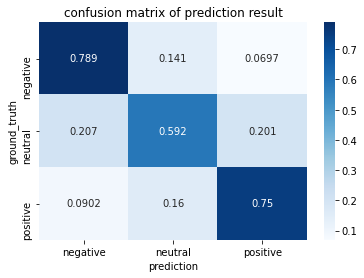

In [38]:
ax = plt.axes()

sn.heatmap(df_cm2, annot=True, fmt='.3g', cmap=plt.cm.Blues) 
ax.set_xlabel("prediction")
ax.set_title('confusion matrix of prediction result')
plt.show() 

In [41]:
pred_df = pd.DataFrame() 
pred_df["truth"] = np.argmax(Y_test, axis = 1) 
pred_df["pred"] = np.argmax(Y_test, axis = 1) 
pred_df.to_csv('test_prediction_result.csv', index=False) 